# Energy Prices Prediction for Day-Ahead Trading

---
> Marcel Pie,
December 2023


We would like to predict the energy prices for the day-ahead market, with the objective of optimising the revenue-earning potential of the battery asset. We dispose of 3 datasets. The notebook is organized as follows:

I - Discovery of the data and understanding the trends and seasonalities within the data.

II - Implementation of an adapted predictive model to forecast the prices.

III - Asset optimization approaches.

## I - Exploratory Analysis

### 1- Data import and some statistics

**Data import**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
import statsmodels.api as sm

In [ ]:
# Enable grid for all plots
plt.rcParams['axes.grid'] = True

In [ ]:
# Load data
df_energy_prices = pd.read_csv('power_prices_realized.csv',  parse_dates=['delivery_time_utc'], index_col='delivery_time_utc')
df_power_demand = pd.read_csv('power_load_forecast.csv',  parse_dates=['delivery_time_utc'], index_col='delivery_time_utc')
df_energy_origin = pd.read_csv('renewables_production_forecast.csv',  parse_dates=['delivery_time_utc'], index_col='delivery_time_utc')

# Sort by timestamp
df_energy_prices.sort_values('delivery_time_utc', inplace=True)
df_power_demand.sort_values('delivery_time_utc', inplace=True)
df_energy_origin.sort_values('delivery_time_utc', inplace=True)

df_list = [df_energy_prices, df_power_demand, df_energy_origin]

In [ ]:
df_energy_prices.head()

,da_price
delivery_time_utc,
2021-12-31 23:00:00,82.02
2021-12-31 23:15:00,82.02
2021-12-31 23:30:00,82.02
2021-12-31 23:45:00,82.02
2022-01-01 00:00:00,67.07


**Data visualization**

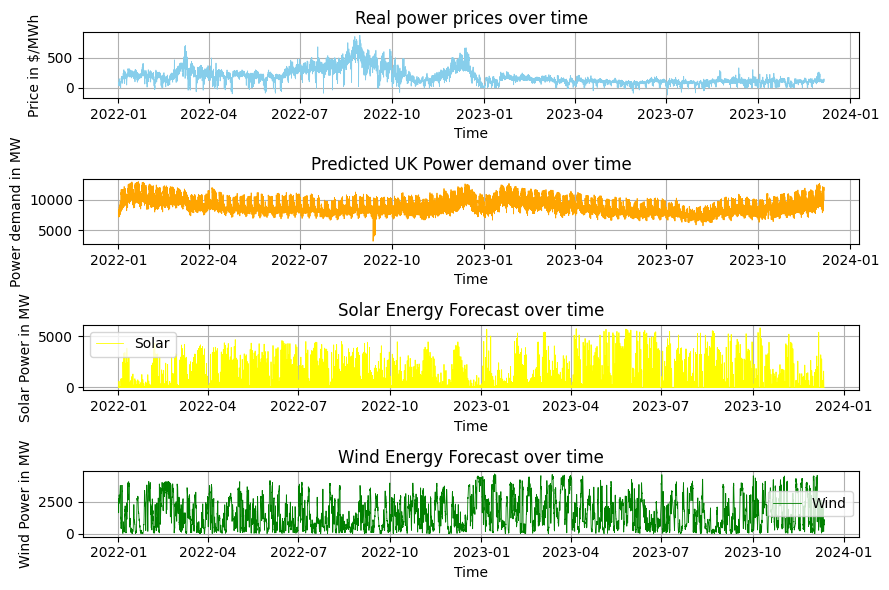

In [ ]:
plt.figure(figsize=(9, 6))

# Plot 1: Real power prices over time
plt.subplot(411)
plt.plot(df_energy_prices.index, df_energy_prices['da_price'], color='skyblue', linewidth=0.6)
plt.xlabel('Time')
plt.ylabel('Price in $/MWh')
plt.title('Real power prices over time')

# Plot 2: Predicted UK Power demand over time
plt.subplot(412)
plt.plot(df_power_demand.index, df_power_demand['power_demand_forecast'], color='orange', linewidth=0.6)
plt.xlabel('Time')
plt.ylabel('Power demand in MW')
plt.title('Predicted UK Power demand over time')

# Plot 3: Plots for Solar and Wind Energy Forecast over time
plt.subplot(413)
plt.plot(df_energy_origin.index, df_energy_origin['solar_forecast'], color='yellow', label='Solar', linewidth=0.6)
plt.xlabel('Time')
plt.ylabel('Solar Power in MW')
plt.title('Solar Energy Forecast over time')
plt.legend()

plt.subplot(414)
plt.plot(df_energy_origin.index, df_energy_origin['wind_forecast'], color='green', label='Wind', linewidth=0.6)
plt.xlabel('Time')
plt.ylabel('Wind Power in MW')
plt.title('Wind Energy Forecast over time')
plt.legend()

plt.tight_layout()
plt.show()

**Basic statistics**

In [ ]:
def generate_summary(df):
  '''
  Generates summary statistics for a DataFrame.
  '''
  # Calculate daily variation
  daily_var = df.resample('D').apply(lambda x: x.max() - x.min())

  summary = pd.DataFrame({
      'Mean': df.mean().astype(int),
      'Std': df.std().astype(int),
      '1st Quantile': df.quantile(0.25),
      '2nd Quantile': df.quantile(0.50),
      '3rd Quantile': df.quantile(0.75),
      'Min': df.min(),
      'Max': df.max(),
      'Start Date': df.index.min(),
      'End Date': df.index.max(),
      'Avg Daily Variation': daily_var.mean().astype(int),
      'Max Daily Variation': daily_var.max().astype(int),
      'Min Daily Variation': daily_var.min()
    })
  print('\n', df.dtypes)
  return summary

# Generating summary statistics for each dataframe
summary_energy_prices = generate_summary(df_energy_prices)
summary_power_demand = generate_summary(df_power_demand)
summary_energy_origin = generate_summary(df_energy_origin)

descriptive_stats = pd.concat([summary_energy_prices, summary_power_demand, summary_energy_origin], axis=0)


 da_price    float64
dtype: object

 power_demand_forecast    float64
dtype: object

 solar_forecast    float64
wind_forecast     float64
dtype: object


In [ ]:
descriptive_stats

,Mean,Std,1st Quantile,2nd Quantile,3rd Quantile,Min,Max,Start Date,End Date,Avg Daily Variation,Max Daily Variation,Min Daily Variation
da_price,194,131,99.990,163.95,256.5800,-120.00,871.00,2021-12-31 23:00:00,2023-12-05 22:00:00,148,679,0.00
power_demand_forecast,9199,1311,8183.750,9183.50,10158.0000,3153.00,12965.00,2021-12-31 23:00:00,2023-12-05 22:00:00,2781,7075,0.00
solar_forecast,791,1242,0.000,15.51,1226.4700,0.00,5823.21,2021-12-31 23:00:00,2023-12-11 23:45:00,2588,5823,0.00
wind_forecast,1579,1234,487.305,1275.90,2527.3775,5.72,4628.22,2021-12-31 23:00:00,2023-12-11 23:45:00,1428,3878,58.17


High variance for the day-ahead prices within a same day -> possibility of making a profit with the battery. Otherwise battery efficency of 91% would make this harder.

**Check for missing values and chronology**


In [ ]:
for df in df_list:
  # Check if data is in chronological order and equidistant timestamps
  print('Is data in chronological order? : ', df.index.is_monotonic_increasing)
  print('\nDifferent timestamp frequencies within the data:\n', df.index.to_series().diff().value_counts())

  # Check for missing values
  print("\nMissing Values:")
  print(df.isnull().sum())
  print('\n-------------------------\n')

Is data in chronological order? :  True

Different timestamp frequencies within the data:
 0 days 00:15:00    48948
0 days 01:00:00     4650
0 days 00:00:00       41
0 days 00:30:00        7
0 days 00:45:00        6
Name: delivery_time_utc, dtype: int64

Missing Values:
da_price    0
dtype: int64

-------------------------

Is data in chronological order? :  True

Different timestamp frequencies within the data:
 0 days 01:00:00    16891
0 days 00:00:00       46
0 days 02:00:00        2
Name: delivery_time_utc, dtype: int64

Missing Values:
power_demand_forecast    0
dtype: int64

-------------------------

Is data in chronological order? :  True

Different timestamp frequencies within the data:
 0 days 00:15:00    66897
0 days 00:00:00      188
1 days 00:15:00       11
0 days 01:15:00        1
0 days 02:15:00        1
1 days 22:15:00        1
Name: delivery_time_utc, dtype: int64

Missing Values:
solar_forecast    0
wind_forecast     0
dtype: int64

-------------------------



In majority, the data is given every 15min for the day-ahead prices and for the energy origin forecast, and every 1h for the power demand forecast. There is a small number of irregularities in the frequency that can be adressed before using a predictive model.

**Duplicate values:**

In [ ]:
for df in df_list:
  # Check for duplicate timestamps in the index
  duplicates = df.index.duplicated(keep='first')

  # Count the number of duplicates
  num_duplicates = duplicates.sum()

  if num_duplicates > 0:
      print(f"\nThe DataFrame contains {num_duplicates} duplicate timestamps.")
  else:
      print("No duplicate timestamps found in the DataFrame.")

  # Extract rows with duplicate timestamps
  duplicate_rows = df[duplicates]

  # Group by index (timestamp) and check for different values within each group
  groups = duplicate_rows.groupby(duplicate_rows.index)
  max_differences = {}

  for name, group in groups:
      max_diff = group.max() - group.min()  # Calculate difference within each group
      max_differences[name] = max_diff.max()  # Store the max difference

  if max_differences:
      max_diff_timestamp = max(max_differences, key=max_differences.get)
      print(f"The maximum difference between values at duplicate timestamps is {max_differences[max_diff_timestamp]} "
            f"at timestamp {max_diff_timestamp}.")
  else:
      print("All duplicate timestamps have the same values.")


The DataFrame contains 41 duplicate timestamps.
The maximum difference between values at duplicate timestamps is 0.0 at timestamp 2023-05-07 22:00:00.

The DataFrame contains 46 duplicate timestamps.
The maximum difference between values at duplicate timestamps is 0.0 at timestamp 2023-10-28 22:00:00.

The DataFrame contains 188 duplicate timestamps.
The maximum difference between values at duplicate timestamps is 0.0 at timestamp 2023-10-28 22:00:00.


There are duplicate timestamps within our data but their values are not different. Let's remove them.

In [ ]:
df_energy_prices = df_energy_prices[~df_energy_prices.index.duplicated(keep='first')]
df_power_demand = df_power_demand[~df_power_demand.index.duplicated(keep='first')]
df_energy_origin = df_energy_origin[~df_energy_origin.index.duplicated(keep='first')]

### 2- Time-series analysis

The forecasted data (power demand and energy origin) appears to contains clear seasonality patterns. The real day-ahead prices time-series seems to be more complex. Let's take a closer look at the data to better understand it.

**Weekly view (first week of October 2022):**

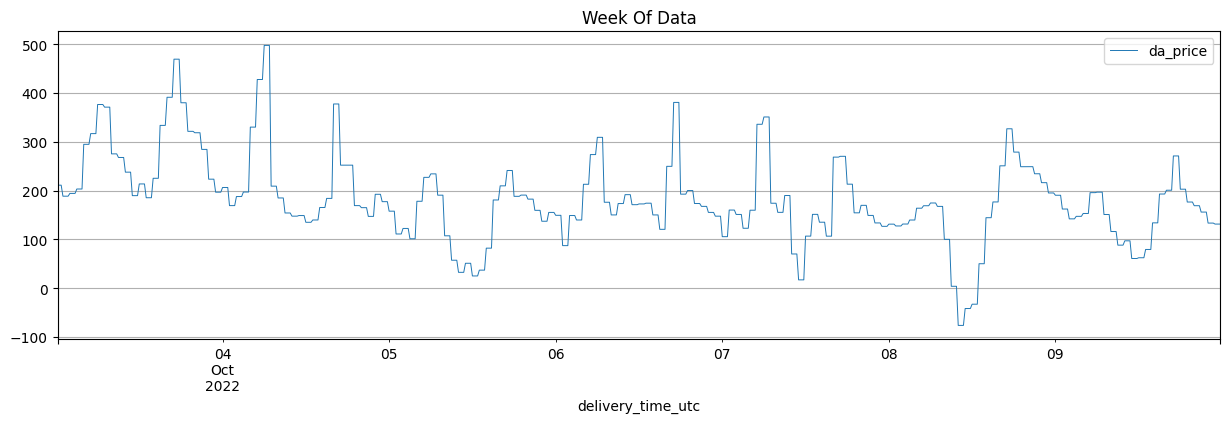

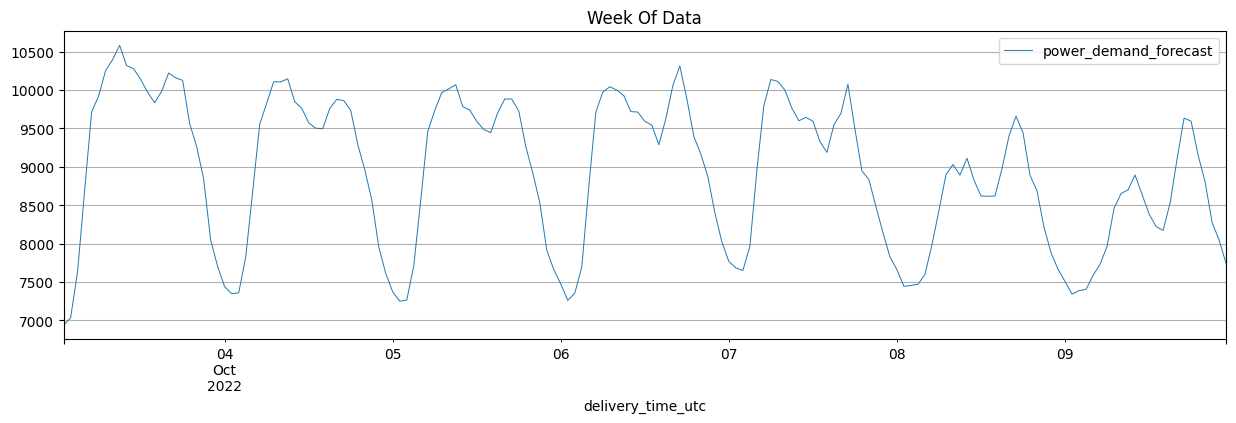

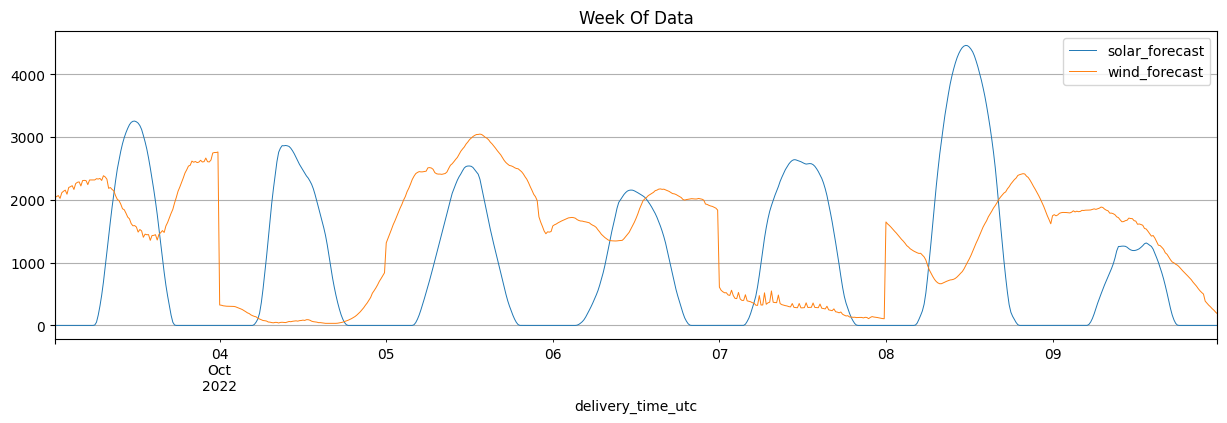

In [ ]:
for df in df_list:
  df.loc[(df.index > '10-03-2022') & (df.index < '10-10-2022')] \
      .plot(figsize=(15, 4), title='Week Of Data', linewidth=0.7)
  plt.show()

At a first glance, the data may contain **seasonal patterns** and **curvilinear trends**. For instance:
- The energy price decreases at the middle of the day and is higher in the mornings and evenings. It has a higher level of **noise** and a seemingly more **random** behaviour than the other time-series.
- The power demand level seems to have a **daily periodicity**, being low during the night and lower in general during the weekends.
- The energy production coming from solar shows daily patterns with higher levels during the day and is neglectable at night.
The wind power **does not show a clear seasonality** at the scale of one week.

**Monthly view (October 2022):**

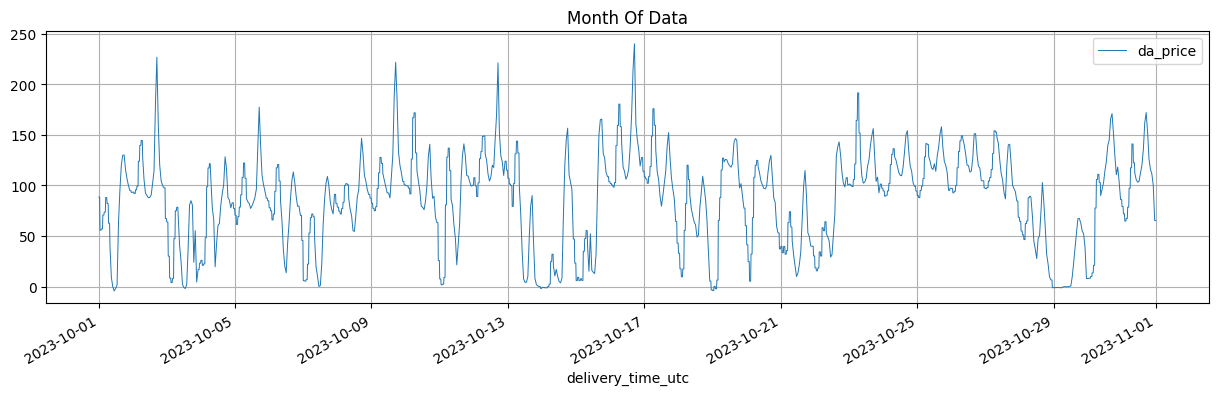

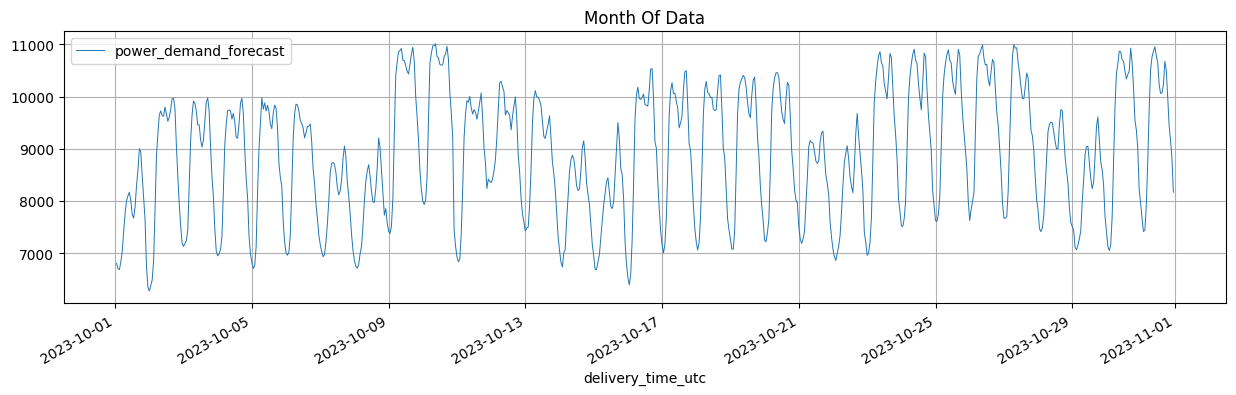

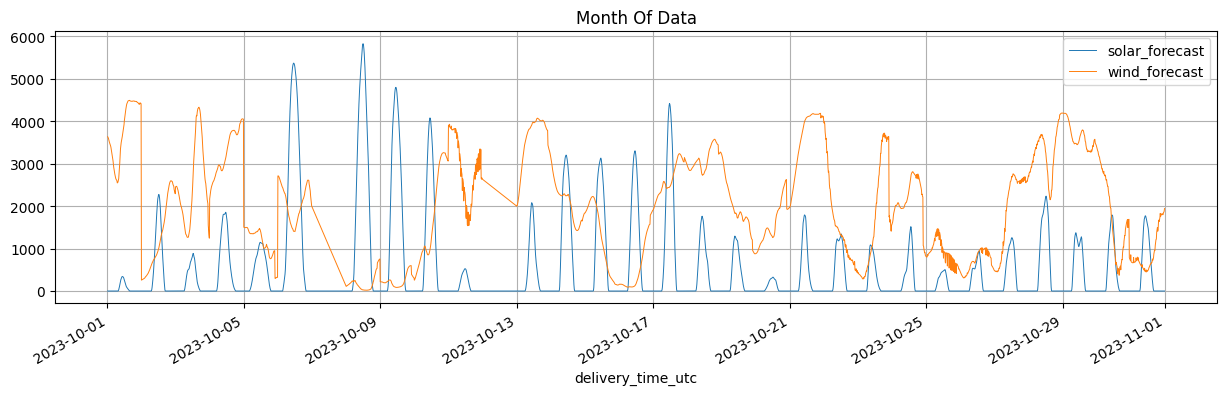

In [ ]:
for df in df_list:
  df.loc[(df.index > '10-01-2023') & (df.index < '11-01-2023')] \
      .plot(figsize=(15, 4), title='Month Of Data', linewidth=0.7)
  plt.show()

By looking at the plots:
- The energy price data contains **outliers**.
- The weekly seasonality of power demand (being lower on the weekends) seems to be confirmed. This should impact the energy prices.
- We can see a trend for the solar energy levels which decreases as the month of October passes and we get into the winter.


**Yearly view (2022):**

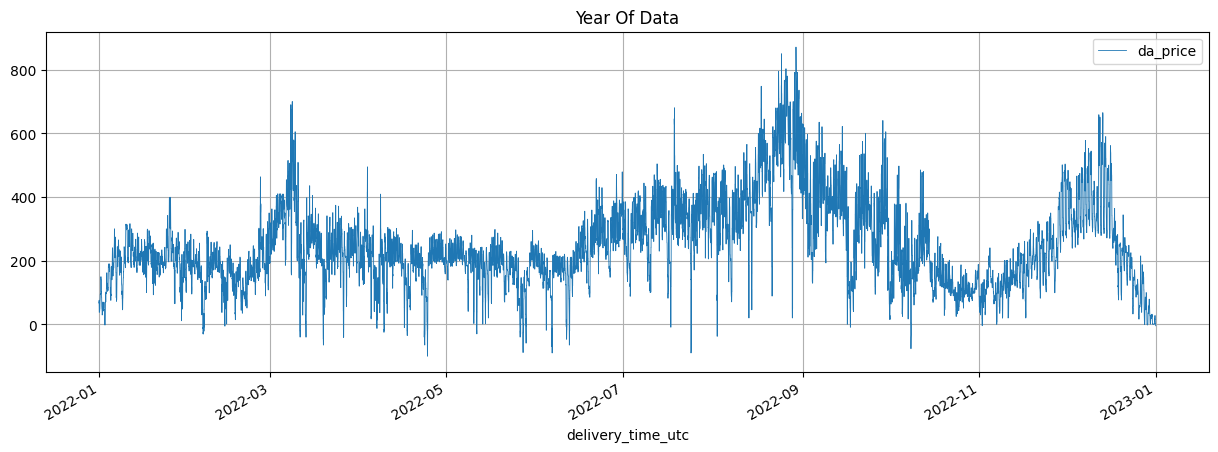

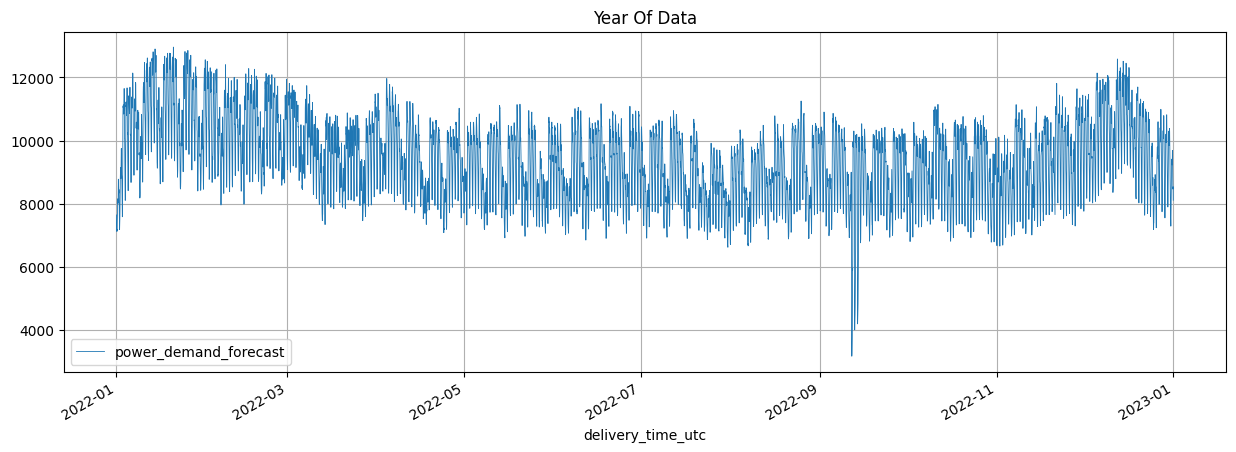

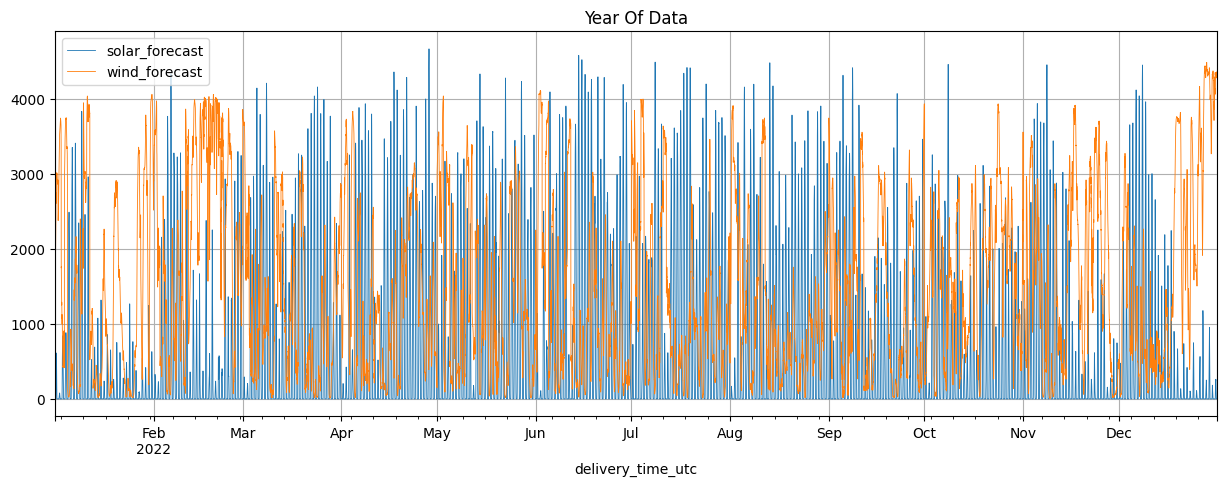

In [ ]:
for df in df_list:
  df.loc[(df.index > '01-01-2022') & (df.index < '01-01-2023')] \
      .plot(figsize=(15, 5), title='Year Of Data', linewidth=0.6)
  plt.show()

For 2023:

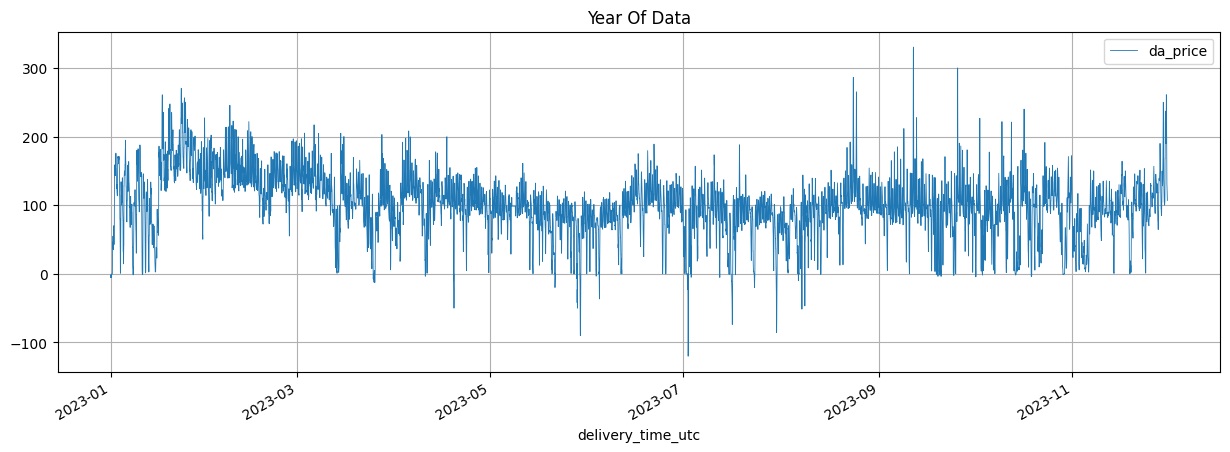

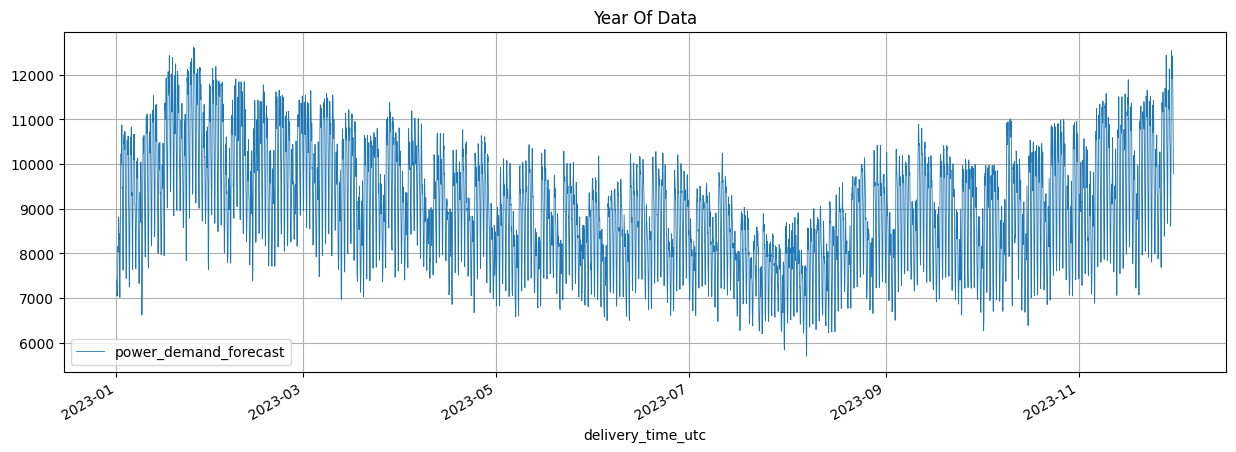

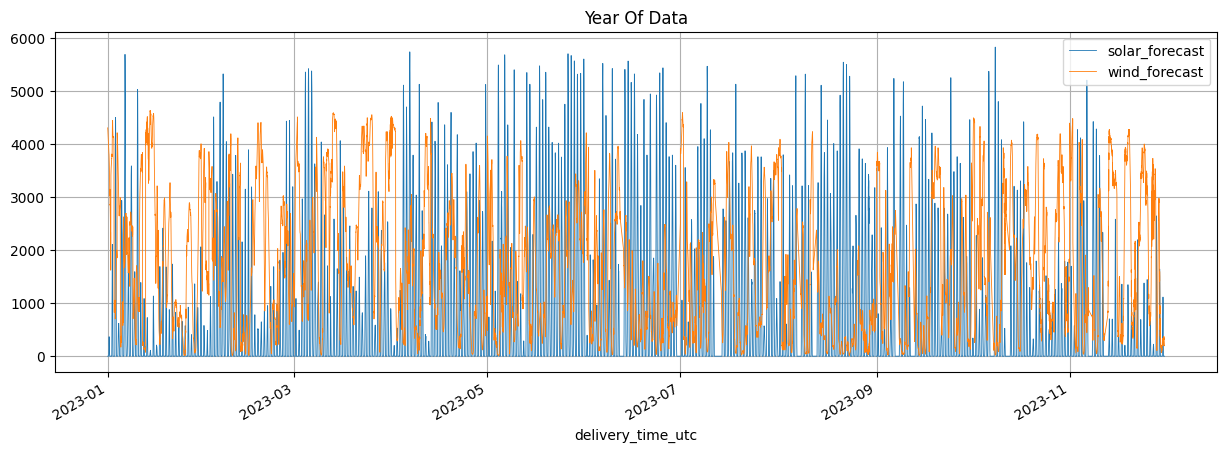

In [ ]:
for df in df_list:
  df.loc[(df.index > '01-01-2023') & (df.index < '12-01-2023')] \
      .plot(figsize=(15, 5), title='Year Of Data', linewidth=0.6)
  plt.show()

Approximative tendencies:

- Higher energy prices during the summer, peaking in September, and getting into the winter. An abnormal drop of power demand during September 2022, which did not happen on 2023.

- The seasonality of solar power seems to be confirmed, rising during the summer.

- Wind power production seems to show a slight tendency, increasing during the winter.

- An irregularity in the power demand forecast: a big drop around September 2022, rapidly followed by a big decrease in the energy prices.

- The daylight saving time in the UK: clock goes back 1h at the end of October and forth 1h at the end of March. This means that we need 1 more daily hour of artificial light overnight starting in October, and 1 less daily hour starting in March. This seems to fit with the energy demand/price decreasing after March and rising after October.

From what we observe, energy prices might be affected by:
- Working days / weekends
- Working hours during the day
- Daily hours of natural light
- Seasons (weather)
- Holidays
- Daylight saving
- External events

---

**We want to implement a model that takes into account the inter-dependencies of our data to better predict the day-ahead prices.**

Auto-regressive models and machine learning models are two common approaches to this challenge.


---



**Feature/Target relationship**

Let's take a look at the average relation between time features and the energy price

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df


df_energy_prices_extra = create_features(df_energy_prices)
df_power_demand_extra = create_features(df_power_demand)
df_power_origin_extra = create_features(df_energy_origin)

df_energy_prices_extra.head()

,da_price,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
delivery_time_utc,,,,,,,,,
2021-12-31 23:00:00,82.02,23,4,4,12,2021,365,31,52
2021-12-31 23:15:00,82.02,23,4,4,12,2021,365,31,52
2021-12-31 23:30:00,82.02,23,4,4,12,2021,365,31,52
2021-12-31 23:45:00,82.02,23,4,4,12,2021,365,31,52
2022-01-01 00:00:00,67.07,0,5,1,1,2022,1,1,52


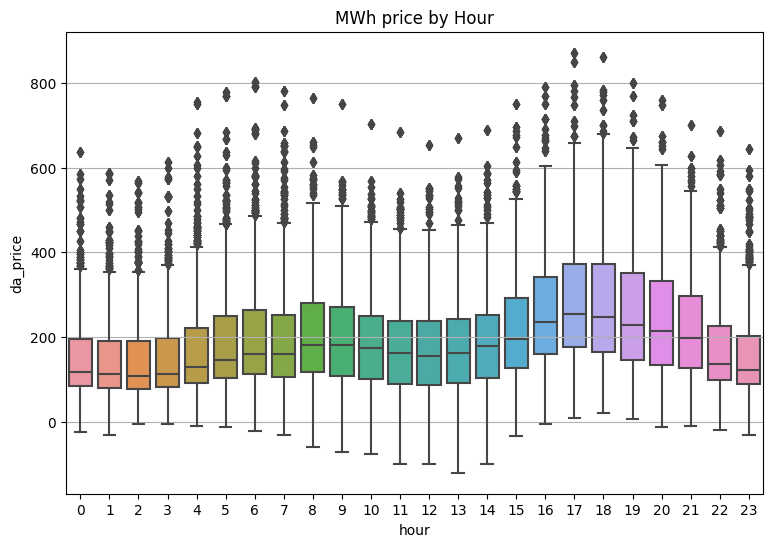

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))
sns.boxplot(data=df_energy_prices_extra, x='hour', y='da_price')
ax.set_title('MWh price by Hour')
plt.show()

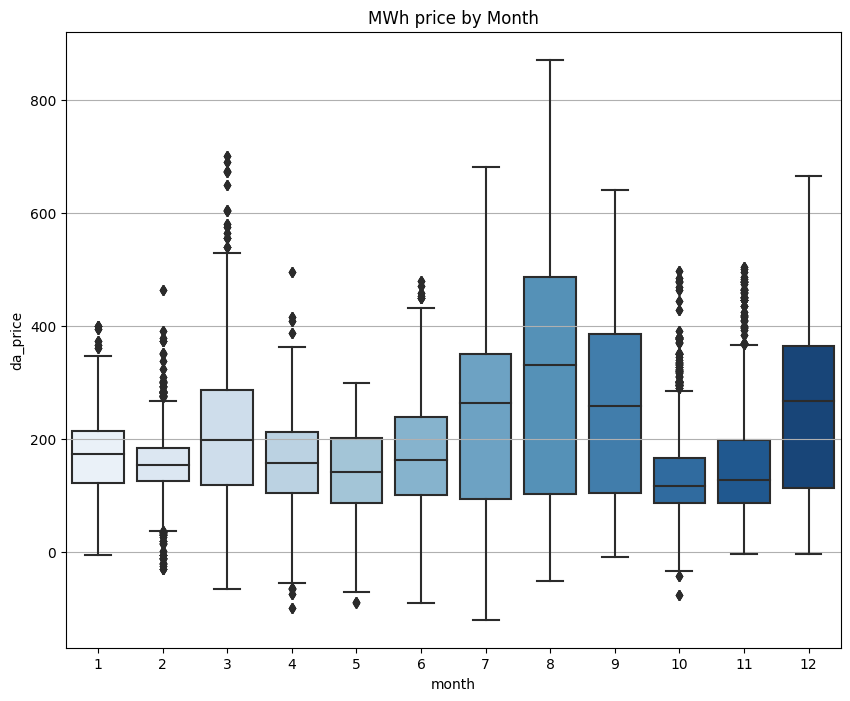

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_energy_prices_extra, x='month', y='da_price', palette='Blues')
ax.set_title('MWh price by Month')
plt.show()

This helps confirming some of our previous hypothesis on the energy prices.

**Let's take a look at seasonality and trends within the data**

The data shows multiple seasonal patterns (daily, weekly, etc), which complicates the task of using a seasonal decomposition.
Let's see how a Seasonal-Trend decomposition using Loess (STL) performs assuming a weekly seasonality.

By doing this, we can determine wether an auto-regressive model or an ML model for forecasting suits our data better.

In [ ]:
eight_week_prices = df_energy_prices.loc[(df_energy_prices.index > '01-01-2022') & (df_energy_prices.index < '26-02-2022')]

<ipython-input-21-7d366f1ac196>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  eight_week_prices = df_energy_prices.loc[(df_energy_prices.index > '01-01-2022') & (df_energy_prices.index < '26-02-2022')]


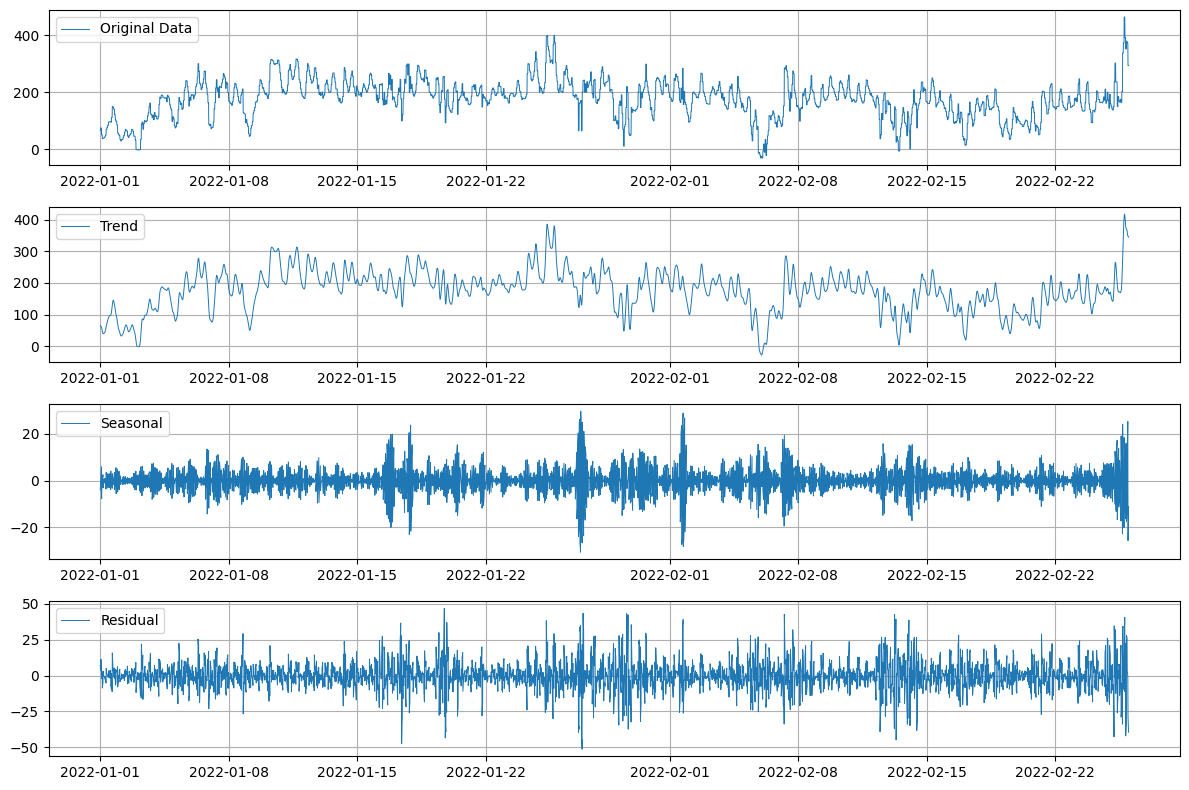

In [ ]:
from statsmodels.tsa.seasonal import STL
import numpy as np

# Decompose the time series using STL: we use a weekly seasonality for a period of 8 weeks
stl = STL(eight_week_prices['da_price'], seasonal=7, period=8)
result = stl.fit()

# Get the seasonal, trend, and residual components
seasonal = result.seasonal
trend = result.trend
residual = result.resid

# Visualize the components
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(eight_week_prices.index, eight_week_prices['da_price'], label='Original Data', linewidth=0.7)
plt.legend()

plt.subplot(412)
plt.plot(eight_week_prices.index, trend, label='Trend', linewidth=0.7)
plt.legend()

plt.subplot(413)
plt.plot(eight_week_prices.index, seasonal, label='Seasonal', linewidth=0.7)
plt.legend()

plt.subplot(414)
plt.plot(eight_week_prices.index, residual, label='Residual', linewidth=0.7)
plt.legend()

plt.tight_layout()
plt.show()

Seasonal decomoposition does not seem capable of properly handling the complexity of our time-series, even at the scale of some weeks.

**Auto-correlation:**

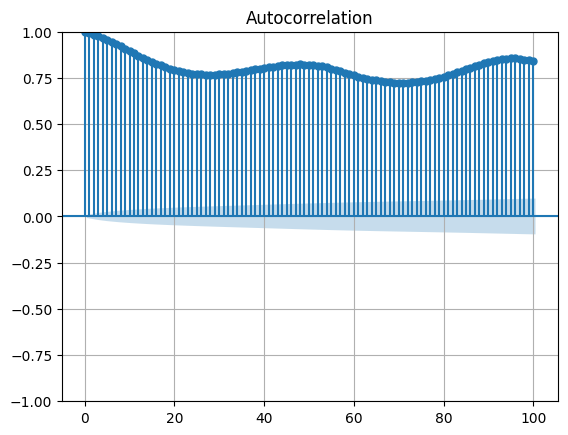

In [ ]:
sm.graphics.tsa.plot_acf(df_energy_prices, lags=100)
plt.show()

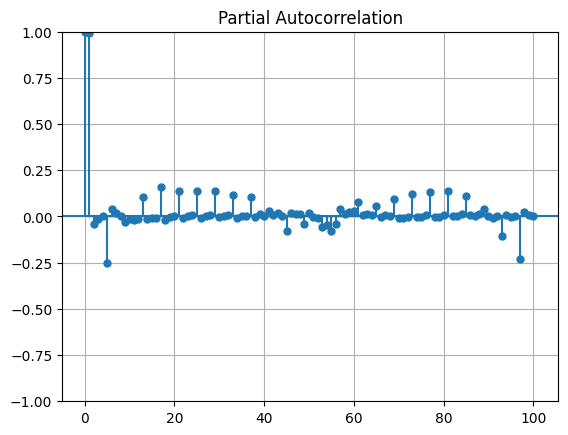

In [ ]:
sm.graphics.tsa.plot_pacf(df_energy_prices, lags=100)
plt.show()

The energy prices seems to be highly correlated to its own lag values. This indicates that an auto-regressive model might be worth trying.

An LSTM can also be a good choice to capture the long-term dependencies in the data.

## II - Predictive modelling

We will use an XGBoost Regressor model because of the following reasons:

- Auto-regressive models are less likely to be able to properly consider the complexity of our data and the non-linear relationships within.

- Overall good performance handling multiple features and possibility to access feature importance.

- Robustness to noise and outliers thanks to regularization terms.

This being said, models like RandomForest (bagging can handle outliers well), LSTM and NN's (like NHITS) are worth trying and comparing.

We will also use cross-validation to obtain better and more representative results when evaluating our model.  We will train the model on data up until day N and use day N+1 as a test set.

### 1- Data formatting


**Resampling the data**

Let's resample the data using interpolation to have a regular 15min frequency

In [ ]:
# Resample data
df_energy_prices_15min = df_energy_prices.resample('15T').mean()
df_power_demand_15min = df_power_demand.resample('15T').mean()
df_energy_origin_15min = df_energy_origin.resample('15T').mean()

merged_df = df_energy_prices_15min.merge(df_power_demand_15min, left_index=True, right_index=True).merge(df_energy_origin_15min, left_index=True, right_index=True)

merged_df

,da_price,power_demand_forecast,solar_forecast,wind_forecast
delivery_time_utc,,,,
2021-12-31 23:00:00,82.02,8367.0,0.0,2600.58
2021-12-31 23:15:00,82.02,NaN,0.0,2570.85
2021-12-31 23:30:00,82.02,NaN,0.0,2519.54
2021-12-31 23:45:00,82.02,NaN,0.0,2476.13
2022-01-01 00:00:00,67.07,8001.0,0.0,2427.40
...,...,...,...,...
2023-12-05 21:00:00,111.55,10261.0,0.0,2294.50
2023-12-05 21:15:00,NaN,NaN,0.0,2284.98
2023-12-05 21:30:00,NaN,NaN,0.0,2133.44


In [ ]:
merged_df[['da_price', 'power_demand_forecast',	'solar_forecast',	'wind_forecast']] = merged_df[['da_price', 'power_demand_forecast',	'solar_forecast',	'wind_forecast']].interpolate(method='linear')
merged_df

,da_price,power_demand_forecast,solar_forecast,wind_forecast
delivery_time_utc,,,,
2021-12-31 23:00:00,82.0200,8367.00,0.0,2600.58
2021-12-31 23:15:00,82.0200,8275.50,0.0,2570.85
2021-12-31 23:30:00,82.0200,8184.00,0.0,2519.54
2021-12-31 23:45:00,82.0200,8092.50,0.0,2476.13
2022-01-01 00:00:00,67.0700,8001.00,0.0,2427.40
...,...,...,...,...
2023-12-05 21:00:00,111.5500,10261.00,0.0,2294.50
2023-12-05 21:15:00,109.4825,10173.75,0.0,2284.98
2023-12-05 21:30:00,107.4150,10086.50,0.0,2133.44


### 2- Feature engineering

Let's update our previously defined create_features function to also consider holidays and weekends. Also, let's add laggs to our data.

Since our forecasting horizon is 24h, we will add laggs smaller than 24h.

In [ ]:
import holidays
import pandas as pd

def create_more_features(df):
    """
    Create time series features based on time series index.
    """
    uk_holidays = holidays.UnitedKingdom()
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    # Create feature for weekends (1 for weekends, 0 for weekdays)
    df['weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

    # Create feature for holidays (1 for holidays, 0 for non-holidays)
    df['holidays'] = df.index.strftime('%Y-%m-%d').isin(uk_holidays).astype(int)

    return df

In [ ]:
def add_lag(df):
    target_map = df['da_price'].to_dict()
    for i in range(8, 25, 8):  # Adding lags from 1 to 24 hours at intervals of 8 hours
        lag_name = f'lag{i}'
        lag_timedelta = pd.Timedelta(f'{i} hours')
        df[lag_name] = (df.index - lag_timedelta).map(target_map)
    return df

In [ ]:
complete_df = create_more_features(merged_df)
complete_df = add_lag(complete_df)
complete_df

,da_price,power_demand_forecast,solar_forecast,wind_forecast,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekend,holidays,lag8,lag16,lag24
delivery_time_utc,,,,,,,,,,,,,,,,,
2021-12-31 23:00:00,82.0200,8367.00,0.0,2600.58,23,4,4,12,2021,365,31,52,0,0,NaN,NaN,NaN
2021-12-31 23:15:00,82.0200,8275.50,0.0,2570.85,23,4,4,12,2021,365,31,52,0,0,NaN,NaN,NaN
2021-12-31 23:30:00,82.0200,8184.00,0.0,2519.54,23,4,4,12,2021,365,31,52,0,0,NaN,NaN,NaN
2021-12-31 23:45:00,82.0200,8092.50,0.0,2476.13,23,4,4,12,2021,365,31,52,0,0,NaN,NaN,NaN
2022-01-01 00:00:00,67.0700,8001.00,0.0,2427.40,0,5,1,1,2022,1,1,52,1,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-05 21:00:00,111.5500,10261.00,0.0,2294.50,21,1,4,12,2023,339,5,49,0,0,119.950,107.97,100.00
2023-12-05 21:15:00,109.4825,10173.75,0.0,2284.98,21,1,4,12,2023,339,5,49,0,0,120.485,107.97,97.94
2023-12-05 21:30:00,107.4150,10086.50,0.0,2133.44,21,1,4,12,2023,339,5,49,0,0,121.020,107.97,95.88


We will use this data for training and testing our model.

The target variable to forecast is da_price.

### 3- Model training

We will train the model on data up until December 4th 2023, and then use it to forecast the 4th and 5th December energy prices using the features (power forecast, energy origin and created features).

The train and testing datasets will be taken from the '*data*' dataframe.
We then will validate our model using the remaining days (4th and 5h December 2023)

In [ ]:
data = complete_df.loc[(complete_df.index < '12-04-2023')]
data.tail()

,da_price,power_demand_forecast,solar_forecast,wind_forecast,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekend,holidays,lag8,lag16,lag24
delivery_time_utc,,,,,,,,,,,,,,,,,
2023-12-03 22:45:00,92.645,8973.50,0.0,4050.43,22,6,4,12,2023,337,3,48,1,0,120.400,92.57,109.1025
2023-12-03 23:00:00,93.860,8756.00,0.0,4324.52,23,6,4,12,2023,337,3,48,1,0,122.200,97.02,109.2000
2023-12-03 23:15:00,93.860,8662.75,0.0,4347.90,23,6,4,12,2023,337,3,48,1,0,123.625,97.02,109.2000
2023-12-03 23:30:00,93.860,8569.50,0.0,4370.19,23,6,4,12,2023,337,3,48,1,0,125.050,97.02,109.2000
2023-12-03 23:45:00,93.860,8476.25,0.0,4390.03,23,6,4,12,2023,337,3,48,1,0,126.475,97.02,109.2000


Let's use TimeSeriesSplit to perform a cross validation:

We use the last day of the data for testing, and the model is trained on the previous data.
We then drop this day and repeat the process with the day before, and so on.

This way, we train data up until day N and test it on day N+1 iteratively.

In [ ]:
# Test size of 96 means there are 96 15min timestamps (adding up to 24h) for each test set
# n_splits of 7 means we repeat training using the last 7 days as test sets separetely
tss = TimeSeriesSplit(n_splits=7, test_size=96, gap=0)

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(data):
    train = data.iloc[train_idx]
    test = data.iloc[val_idx]

    X_train = train.drop('da_price', axis=1)
    y_train = train['da_price']

    X_test = test.drop('da_price', axis=1)
    y_test = test['da_price']

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           colsample_bytree=0.6,
                           subsample=0.6,
                           alpha=1,
                           gamma=0,
                           n_estimators=700,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.005)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:214.40404	validation_1-rmse:116.14178
[100]	validation_0-rmse:139.39308	validation_1-rmse:74.11423
[200]	validation_0-rmse:95.73794	validation_1-rmse:47.78802
[300]	validation_0-rmse:71.74845	validation_1-rmse:33.05344
[400]	validation_0-rmse:58.99716	validation_1-rmse:24.29340
[500]	validation_0-rmse:52.34971	validation_1-rmse:19.94638
[600]	validation_0-rmse:48.67559	validation_1-rmse:18.64991
[699]	validation_0-rmse:46.45925	validation_1-rmse:18.44814
[0]	validation_0-rmse:214.29525	validation_1-rmse:126.86120
[100]	validation_0-rmse:139.31838	validation_1-rmse:85.01441
[200]	validation_0-rmse:95.69325	validation_1-rmse:58.73473
[300]	validation_0-rmse:71.72502	validation_1-rmse:42.41378
[400]	validation_0-rmse:58.99107	validation_1-rmse:32.43108
[500]	validation_0-rmse:52.33742	validation_1-rmse:26.52140
[600]	validation_0-rmse:48.65727	validation_1-rmse:22.98473
[699]	validation_0-rmse:46.43457	validation_1-rmse:20.76618
[0]	validation_0-rmse:214.19545	valida

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 24.1108
Fold scores:[18.4372571247136, 20.766177824977078, 33.714979380881886, 48.41858185914855, 29.130619443171444, 8.994172267859707, 9.314093584229402]


Let's perform a second cross validation, this time using testing sets from a different season.

In [ ]:
data2 = data.loc[data.index < '07-15-2023']

In [ ]:
preds = []
scores = []
for train_idx, val_idx in tss.split(data2):
    train = data2.iloc[train_idx]
    test = data2.iloc[val_idx]

    X_train = train.drop('da_price', axis=1)
    y_train = train['da_price']

    X_test = test.drop('da_price', axis=1)
    y_test = test['da_price']

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           colsample_bytree=0.6,
                           subsample=0.6,
                           alpha=1,
                           gamma=0,
                           n_estimators=600,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.005)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:235.45407	validation_1-rmse:87.95235
[100]	validation_0-rmse:152.55321	validation_1-rmse:51.81060
[200]	validation_0-rmse:104.34820	validation_1-rmse:33.51824
[300]	validation_0-rmse:77.83613	validation_1-rmse:24.49289
[400]	validation_0-rmse:63.71512	validation_1-rmse:20.17235
[500]	validation_0-rmse:56.38450	validation_1-rmse:17.43947
[599]	validation_0-rmse:52.33313	validation_1-rmse:14.27079
[0]	validation_0-rmse:235.27049	validation_1-rmse:92.71047
[100]	validation_0-rmse:152.42993	validation_1-rmse:56.34831
[200]	validation_0-rmse:104.24545	validation_1-rmse:37.20259
[300]	validation_0-rmse:77.75013	validation_1-rmse:26.64062
[400]	validation_0-rmse:63.63047	validation_1-rmse:20.93688
[500]	validation_0-rmse:56.31171	validation_1-rmse:16.77999
[599]	validation_0-rmse:52.27195	validation_1-rmse:13.65276
[0]	validation_0-rmse:235.09185	validation_1-rmse:116.36501
[100]	validation_0-rmse:152.31575	validation_1-rmse:78.43496
[200]	validation_0-rmse:104.16801	val

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 18.9472
Fold scores:[14.26835996046081, 13.652761715168237, 27.44481770803098, 20.860144123222625, 31.776061727058387, 13.796692138636683, 10.831580947801815]


**We obtain an RMSE of 18,9 meaning that, on average, the model's predictions deviate from the actual price by around 18 pounds/MWh.**

Under the hypothesis of a battery that has 100% efficency: This means that in order to have a positive expected return, we need to make sure that there is a difference of at least 38 pounds on the energy prices between the moment we buy and sell based on the day-ahead forecast.

For our battery, the efficency must also be considered.

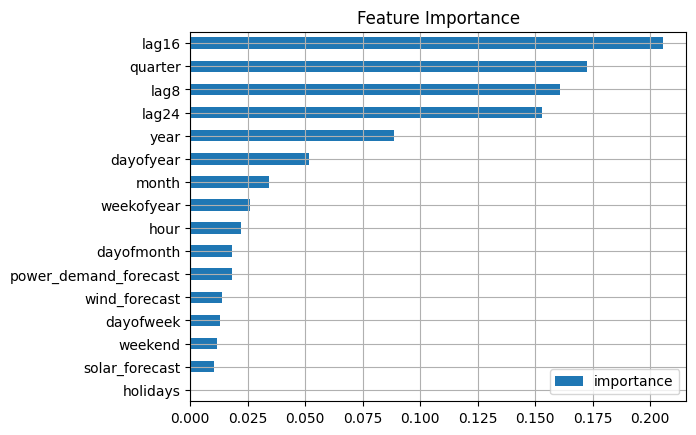

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

Let's take a look at the forecasting results for a given day.

In [ ]:
test_set = data.loc[data.index >= '2023-12-03 00:00:00']

In [ ]:
test_set['pred'] = reg.predict(test_set.drop('da_price', axis=1))

<ipython-input-38-63cf01b29b21>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['pred'] = reg.predict(test_set.drop('da_price', axis=1))


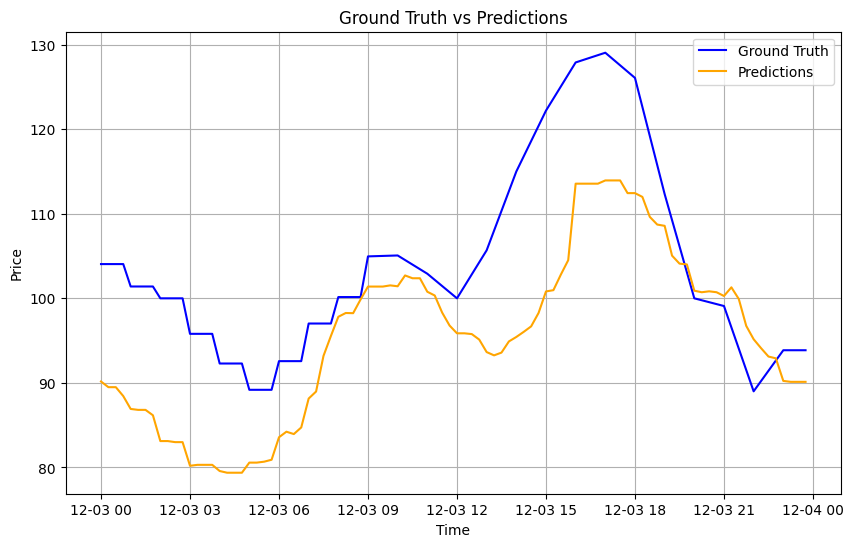

In [ ]:
plt.figure(figsize=(10, 6))

# Plot ground truth for 'da_price'
plt.plot(test_set.index, test_set['da_price'], label='Ground Truth', color='blue')

# Plot predictions from future_df
plt.plot(test_set.index, test_set['pred'], label='Predictions', color='orange')

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Ground Truth vs Predictions')
plt.legend()
plt.grid(True)

plt.show()

### 4- Forecasting the day-ahead prices

Let's first retrain our model on all data since the last day of the training set is also used for training

In [ ]:
# Retrain on all data without the 4th and 5th of December 2023
X_all = data.drop('da_price', axis=1)
y_all = data['da_price']

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:212.74540
[100]	validation_0-rmse:93.46663
[200]	validation_0-rmse:57.76888
[300]	validation_0-rmse:48.12256
[400]	validation_0-rmse:44.54293
[499]	validation_0-rmse:42.90352


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
print('Last timestamp of the training and testing data: ', data.index.max())

Last timestamp of the training and testing data:  2023-12-03 23:45:00


Let's now create a "future" DataFrame containing the features for prediction for the day-ahead (in this case a bit more: the 4th and 5th December). We'll then use our model to predict the energy prices for this validation set.

In [ ]:
# Let's take our complete data before feature engineering (merged_df)
# and delete the price values for the 4th and 5th of December 2023
condition = merged_df.index >= '2023-12-04 00:00:00'
merged_df.loc[condition, 'da_price'] = float('nan')
merged_df

,da_price,power_demand_forecast,solar_forecast,wind_forecast
delivery_time_utc,,,,
2021-12-31 23:00:00,82.02,8367.00,0.0,2600.58
2021-12-31 23:15:00,82.02,8275.50,0.0,2570.85
2021-12-31 23:30:00,82.02,8184.00,0.0,2519.54
2021-12-31 23:45:00,82.02,8092.50,0.0,2476.13
2022-01-01 00:00:00,67.07,8001.00,0.0,2427.40
...,...,...,...,...
2023-12-05 21:00:00,NaN,10261.00,0.0,2294.50
2023-12-05 21:15:00,NaN,10173.75,0.0,2284.98
2023-12-05 21:30:00,NaN,10086.50,0.0,2133.44


In [ ]:
# Create future dataframe
merged_dff = merged_df.copy()
merged_dff = create_more_features(merged_dff)
merged_dff = add_lag(merged_dff)
future_df = merged_dff.loc[merged_dff.index >= '2023-12-04 00:00:00']
future_df

,da_price,power_demand_forecast,solar_forecast,wind_forecast,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekend,holidays,lag8,lag16,lag24
delivery_time_utc,,,,,,,,,,,,,,,,,
2023-12-04 00:00:00,NaN,8383.00,0.0,4113.25,0,0,4,12,2023,338,4,49,0,0,127.9000,100.15,104.05
2023-12-04 00:15:00,NaN,8296.50,0.0,4138.93,0,0,4,12,2023,338,4,49,0,0,128.1875,100.15,104.05
2023-12-04 00:30:00,NaN,8210.00,0.0,4157.10,0,0,4,12,2023,338,4,49,0,0,128.4750,100.15,104.05
2023-12-04 00:45:00,NaN,8123.50,0.0,4175.10,0,0,4,12,2023,338,4,49,0,0,128.7625,100.15,104.05
2023-12-04 01:00:00,NaN,8037.00,0.0,4189.70,1,0,4,12,2023,338,4,49,0,0,129.0500,104.96,101.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-05 21:00:00,NaN,10261.00,0.0,2294.50,21,1,4,12,2023,339,5,49,0,0,NaN,NaN,NaN
2023-12-05 21:15:00,NaN,10173.75,0.0,2284.98,21,1,4,12,2023,339,5,49,0,0,NaN,NaN,NaN
2023-12-05 21:30:00,NaN,10086.50,0.0,2133.44,21,1,4,12,2023,339,5,49,0,0,NaN,NaN,NaN


Let's now forecast the energy prices and compare them to the real ones

In [ ]:
future_dff = future_df.copy()
future_dff['pred'] = reg.predict(future_dff.drop('da_price', axis=1))

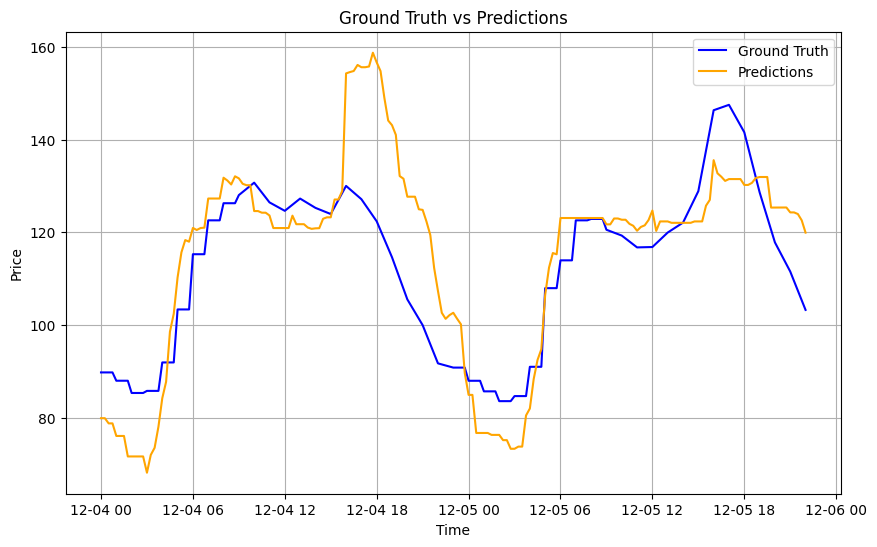

In [ ]:
truth = df_energy_prices.loc[df_energy_prices.index >= '2023-12-04 00:00:00']
plt.figure(figsize=(10, 6))

# Plot ground truth for 'da_price'
plt.plot(truth.index, truth['da_price'], label='Ground Truth', color='blue')

# Plot predictions from future_df
plt.plot(future_dff.index, future_dff['pred'], label='Predictions', color='orange')

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Ground Truth vs Predictions')
plt.legend()
plt.grid(True)

plt.show()

Improvement ideas:
- Improve feature engineering
- Hybrid model / incorporate domain knowledge within the model architecture
- Ensemble learning
- Custom error metric that takes into account the asset characteristics

### Comparison with Meta's Prophet model

Did not manage to make this model work on the time given.

In [ ]:
'''merged_df = df_energy_prices_15min.merge(df_power_demand_15min, left_index=True, right_index=True).merge(df_energy_origin_15min, left_index=True, right_index=True)
merged_df[['da_price', 'power_demand_forecast',	'solar_forecast',	'wind_forecast']] = merged_df[['da_price', 'power_demand_forecast',	'solar_forecast',	'wind_forecast']].interpolate(method='linear')'''

"merged_df = df_energy_prices_15min.merge(df_power_demand_15min, left_index=True, right_index=True).merge(df_energy_origin_15min, left_index=True, right_index=True)\nmerged_df[['da_price', 'power_demand_forecast',\t'solar_forecast',\t'wind_forecast']] = merged_df[['da_price', 'power_demand_forecast',\t'solar_forecast',\t'wind_forecast']].interpolate(method='linear')"

For comparison purposes, we'll see how meta's Prophet performs on this task. Let's note that ideally, we would like to compare 3 different models, since it gives us more interpretable results than comparing 2 models...

In [ ]:
'''# Renaming columns and preparing regressors
df_prophet = merged_df.loc[merged_df.index < '12-04-2023']

df_prophet.reset_index(inplace=True)
df_prophet = df_prophet.rename(columns={'delivery_time_utc': 'ds', 'da_price': 'y'})

next_day = merged_df.loc[(merged_df.index >= '12-04-2023') & (merged_df.index < '12-05-2023')]

# Initialize and fit Prophet with additional regressors
model = Prophet()
model.add_regressor('power_demand_forecast')
model.add_regressor('wind_forecast')
model.add_regressor('solar_forecast')

model.fit(df_prophet)

# Create future dataframe with regressor values for predictions
future = pd.date_range(start='12-04-2023', periods=96, freq='15T')
future_df = pd.DataFrame({'ds': future})

# Adding regressor values for future dates
future['power_demand_forecast'] = next_day['power_demand_forecast']
future['wind_forecast'] = next_day['wind_forecast']
future['solar_forecast'] = next_day['solar_forecast']

# Make predictions
forecast = model.predict(future)

plt.figure(figsize=(10, 6))

# Plot Prophet forecast
model.plot(forecast, xlabel='Date', ylabel='Price forecast in $/MWh', ax=plt.gca())

# Plotting the real data
plt.plot(next_day['delivery_time_utc'], next_day['da_price'], label='Real Data', color='red')
plt.legend()

plt.title('Prophet Forecast vs Real Data')
plt.show()'''

"# Renaming columns and preparing regressors\ndf_prophet = merged_df.loc[merged_df.index < '12-04-2023']\n\ndf_prophet.reset_index(inplace=True)\ndf_prophet = df_prophet.rename(columns={'delivery_time_utc': 'ds', 'da_price': 'y'})\n\nnext_day = merged_df.loc[(merged_df.index >= '12-04-2023') & (merged_df.index < '12-05-2023')]\n\n# Initialize and fit Prophet with additional regressors\nmodel = Prophet()\nmodel.add_regressor('power_demand_forecast')\nmodel.add_regressor('wind_forecast')\nmodel.add_regressor('solar_forecast')\n\nmodel.fit(df_prophet)\n\n# Create future dataframe with regressor values for predictions\nfuture = pd.date_range(start='12-04-2023', periods=96, freq='15T')\nfuture_df = pd.DataFrame({'ds': future})\n\n# Adding regressor values for future dates\nfuture['power_demand_forecast'] = next_day['power_demand_forecast']\nfuture['wind_forecast'] = next_day['wind_forecast']\nfuture['solar_forecast'] = next_day['solar_forecast']\n\n# Make predictions\nforecast = model.predi

## III - Asset optimization

We would like to define a strategy for charge and discharge of the battery asset for the period September-December 2023.

This optimization problem must take into account the characteristics of the asset:
- 2h charging time at 10MW power
- 20MWh capacity
- 91% efficiency for charge and for discharge

It would also be pertinent to consider the percentage of change in the time series, since it is directly linked to the return on investment.

There are various approaches and algorithms to solve this optimization problem.

**We will adopt a simple threshold-based approach.**


---


For instance: If price is > x, we discharge the battery, if it is < y we charge it, else we do nothing.

An improvement we will add to this approach is that the **thresholds should depend on the percentage of change (or the derivative) of our time series.**

We will also use the known daily seasonality of the data:


---



In [ ]:
period_df = df_energy_prices.loc[(df_energy_prices.index >= '09-01-2023') & (df_energy_prices.index < '12-01-2023')]
period_df

,da_price
delivery_time_utc,
2023-09-01 00:00:00,93.29
2023-09-01 00:15:00,93.29
2023-09-01 00:30:00,93.29
2023-09-01 00:45:00,93.29
2023-09-01 01:00:00,91.01
...,...
2023-11-30 22:00:00,113.66
2023-11-30 23:00:00,106.91
2023-11-30 23:15:00,106.91


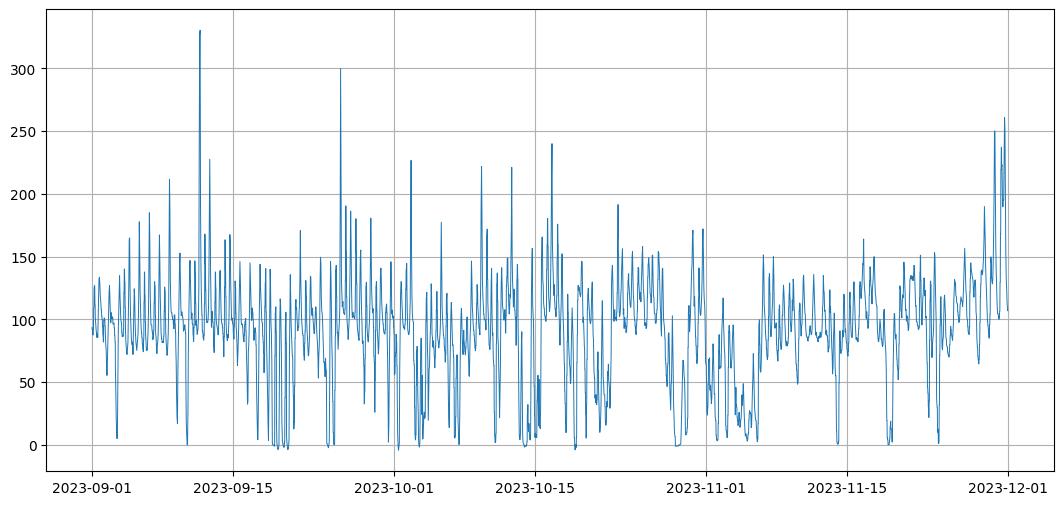

In [ ]:
plt.figure(figsize=(13, 6))
plt.plot(period_df, linewidth=0.7)
plt.show()

Let's see if we can obtain a trend using a simple rolling mean

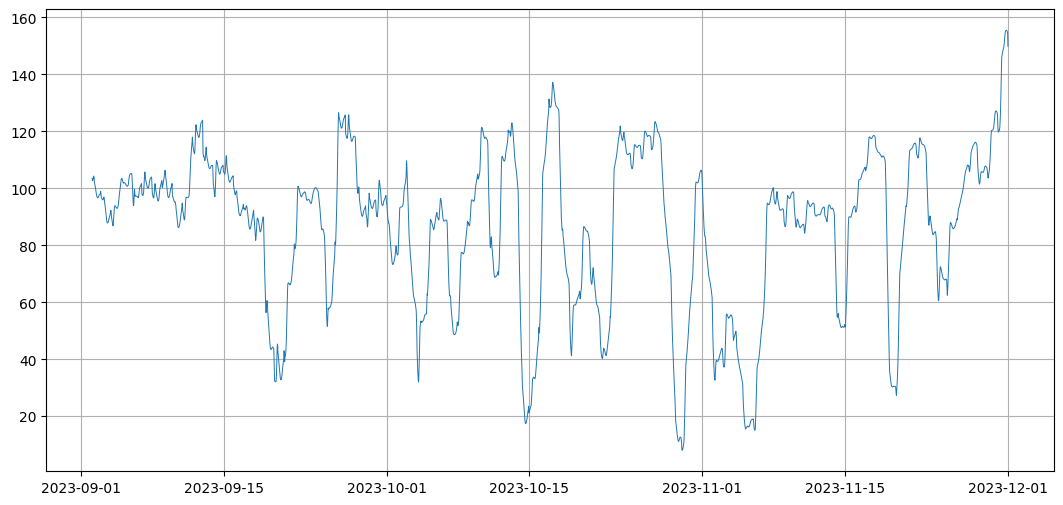

In [ ]:
trend = period_df['da_price'].rolling(64).mean()
plt.figure(figsize=(13, 6))
plt.plot(trend, linewidth=0.7)
plt.show()

Since we want to define the strategy for the day-ahead, let's again boxplot the price vs the hour of the day for the period of interest:

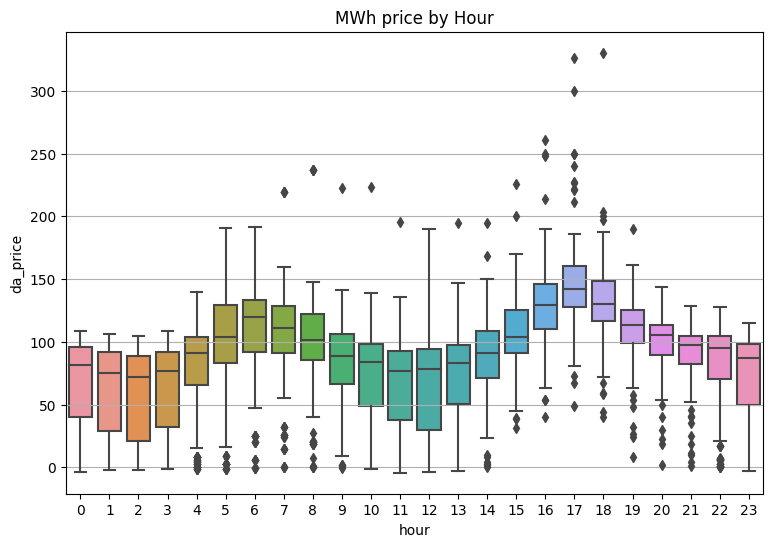

In [ ]:
period_w_features = create_features(period_df)

fig, ax = plt.subplots(figsize=(9, 6))
sns.boxplot(data=period_w_features, x='hour', y='da_price')
ax.set_title('MWh price by Hour')
plt.show()

Let's look at the values and percentage of change for a given day (first day of september):

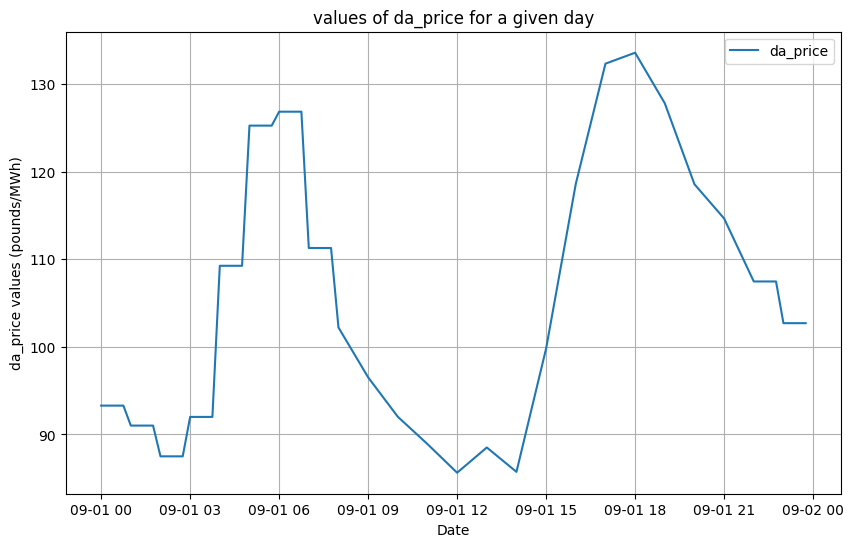

In [ ]:
given_day = period_df['da_price'].loc[period_df.index < '09-02-2023']

plt.figure(figsize=(10, 6))
plt.plot(given_day.index, given_day.values, label='da_price')
plt.xlabel('Date')
plt.ylabel('da_price values (pounds/MWh)')
plt.title('values of da_price for a given day')
plt.legend()
plt.grid(True)
plt.show()

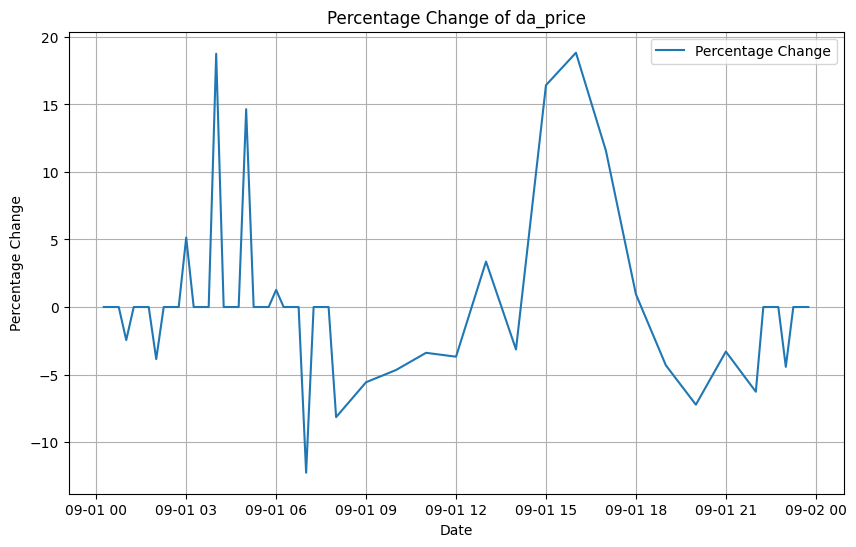

In [ ]:
pct_change = period_df['da_price'].loc[period_df.index < '09-02-2023'].pct_change() * 100

plt.figure(figsize=(10, 6))
plt.plot(pct_change.index, pct_change.values, label='Percentage Change')
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.title('Percentage Change of da_price')
plt.legend()
plt.grid(True)
plt.show()

**More precisely, we define our strategy as follows:**




**Segmentation of Each Day:**

- Identify two time windows: 00:00 to 08:00 and 16:00 to 23:45.
- Find the minimum and maximum prices within these time windows for each day.
- Store the timestamps and price values at these moments.

**Conditions for Buy and Sell:**

Define conditions based on price and percentage change to trigger a buy or sell decision.
Example conditions could be:
- Buy: If the price is the minimum in the morning and satisfies certain percentage change conditions.
- Sell: If the price is the maximum in the evening and satisfies certain percentage change conditions.

Let's say our dataframe containing the predictions for the day-ahead is called df. We could implement a code that looks as follows:

In [ ]:
# Define time windows for min max search
morning_window = df.between_time('00:00', '08:00')
evening_window = df.between_time('16:00', '23:45')

# Find min and max prices and their timestamps
morning_min = morning_window['da_price'].idxmin()
morning_min_price = morning_window['da_price'].min()

morning_max = morning_window['da_price'].idxmax()
morning_max_price = morning_window['da_price'].max()

evening_min = evening_window['da_price'].idxmin()
evening_min_price = evening_window['da_price'].min()

evening_max = evening_window['da_price'].idxmax()
evening_max_price = evening_window['da_price'].max()

KeyError: ignored

We will buy and sell in a 2h window centered at each of this maxs and mins IF they satisfy a given set of conditions.
For instance, for the morning window:

We get the quantiles to help define our thresholds:

In [ ]:
given_day.describe()

count     54.000000
mean     105.021296
std       14.506413
min       85.630000
25%       92.000000
50%      102.700000
75%      113.807500
max      133.570000
Name: da_price, dtype: float64

And define the conditions:

In [ ]:
if pct_change.loc[morning_min+1] > 3: # prices start increasing at a given rate of 300% after the min
  if df[morning_min] < 92: # (1st quantile)
    # we charge the battery
    pass

if pct_change.loc[morning_max+1] < 3: # prices start decreasing at a given rate of 300% after the max
  if df[morning_max] < 113: # (3rd quantile)
    # we discharge the battery
    pass

# Before deciding if we do this, we need to verify that we earn a profit:

if df[morning_min] * 0.91**2 < df[morning_max]:
  #validate decisions
  pass


Finally, we can compute the daily profits based on the day-ahead prediction and compare them with the real profits obtained to evaluate our model predictions in terms of benefit.